# Load Libraries

In [69]:
import warnings
warnings.filterwarnings("ignore")

import time
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

import onnxmltools
import onnxruntime as ort
from onnxmltools.convert import convert_lightgbm

# Code

In [70]:
# 1. Load dataset (example: SMART CSV)
data = pd.read_csv('dataset/smart_manufacturing_data.csv', parse_dates=['timestamp'])
data = data.sort_values(['machine_id','timestamp']).reset_index(drop=True)
data.head()

,timestamp,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk,maintenance_required
0,2025-01-01 01:37:00,1,62.59,48.08,60.13,1.62,4.16,1,0,363,Normal,0.0,0
1,2025-01-01 01:42:00,1,70.88,68.67,50.57,1.05,2.36,1,0,111,Normal,0.0,0
2,2025-01-01 02:13:00,1,62.34,72.68,60.47,2.24,4.95,1,0,192,Normal,0.0,0
3,2025-01-01 02:19:00,1,88.03,53.36,50.79,3.08,2.25,1,0,301,Normal,0.0,0
4,2025-01-01 03:05:00,1,79.39,49.44,56.99,2.54,2.76,1,0,127,Normal,0.0,0


In [71]:
print('Number of machines:', len(set(data['machine_id'].tolist())))
Counter(data["anomaly_flag"].tolist())

Number of machines: 50


Counter({0: 91084, 1: 8916})

Now, we only use 2 features out of 5

In [72]:
# 2. Scale and split features
# Split by machines
machine_train = list(range(1, 41)) # 1-40
machine_test = list(range(41, 51)) # 41-50

# features = ["temperature", "vibration", "humidity", "pressure", "energy_consumption"]
features = ["temperature", "vibration"]

X_train = data[data['machine_id'].isin(machine_train)][features]
X_test = data[data['machine_id'].isin(machine_test)][features]

y_train = data[data['machine_id'].isin(machine_train)]['anomaly_flag']
y_test = data[data['machine_id'].isin(machine_test)]['anomaly_flag']

In [73]:
print('Train:', len(y_train))
print('Test :', len(y_test))

print('Train:', Counter(y_train))
print('Test :', Counter(y_test))

Train: 80095
Test : 19905
Train: Counter({0: 73001, 1: 7094})
Test : Counter({0: 18083, 1: 1822})


In [ ]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
X_train

array([[-1.23854002, -0.12896541],
       [-0.41152895,  1.24339317],
       [-1.26348004,  1.5106665 ],
       ...,
       [-0.04740465,  1.59798023],
       [-0.21101119,  0.01166969],
       [ 0.72773117,  1.02810816]])

In [76]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
80090    0
80091    1
80092    0
80093    0
80094    0
Name: anomaly_flag, Length: 80095, dtype: int64

We run gridsearch at the start to get the best parameters, which is:

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20, 'num_leaves': 31}

Next, we rerun it without using gridsearch to allow us to optimize the model

In [77]:
# 3. Train LightGBM binary classifier
param_grid = {
    'num_leaves': [31, 40],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [10, 20],
    'max_depth': [2, 3]
}

model = lgb.LGBMClassifier()
clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)
clf.fit(X_train, y_train)

best_params = clf.best_params_
print("Best hyperparameters:", best_params)

y_pred = clf.predict(X_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print('')
print(f'Prec={prec:.2f}, Rec={rec:.2f}, F1={f1:.2f}, AUC={roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]):.2f}')


[LightGBM] [Info] Number of positive: 5676, number of negative: 58400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 64076, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088582 -> initscore=-2.331069
[LightGBM] [Info] Start training from score -2.331069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5675, number of negative: 58401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points i

As expected, the temperature and the vibration is the top 2 features to determine the anomaly, which make sense as those are the ones with early signs of issues.

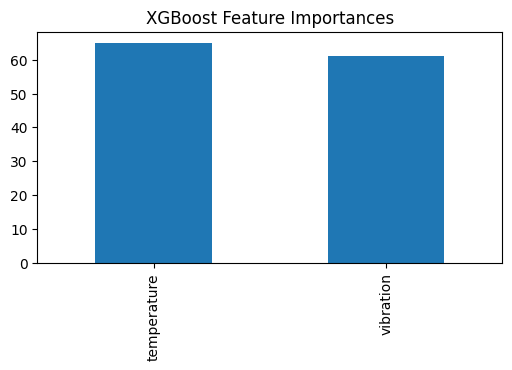

In [78]:
# FEATURE IMPORTANCE
importances = clf.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(6, 3))
plt.title("XGBoost Feature Importances")
plt.show()

Rerun LGBM training with best parameters

In [79]:
model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=3, n_estimators=20, num_leaves=31)
model.fit(X_train, y_train)

y_pred = clf.predict(X_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print('')
print(f'Prec={prec:.2f}, Rec={rec:.2f}, F1={f1:.2f}, AUC={roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.2f}')

[LightGBM] [Info] Number of positive: 7094, number of negative: 73001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 80095, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088570 -> initscore=-2.331224
[LightGBM] [Info] Start training from score -2.331224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [80]:
# Assuming 'model' is your trained LightGBM model
with open('models/model_lgbm_smaller.pkl', 'wb') as f:
    pickle.dump(model, f)

In [81]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18083
           1       1.00      0.97      0.99      1822

    accuracy                           1.00     19905
   macro avg       1.00      0.99      0.99     19905
weighted avg       1.00      1.00      1.00     19905



Confusion matrix:
 [[18083     0]
 [   51  1771]]


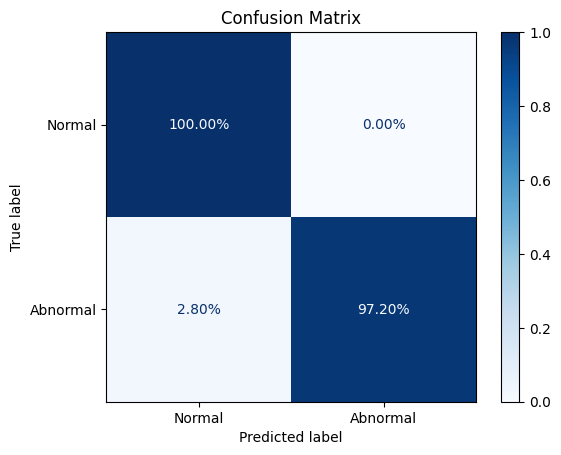

In [82]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Normalize by true labels (rows)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Normal', 'Abnormal'])
disp.plot(cmap=plt.cm.Blues, values_format='.2%')
plt.title("Confusion Matrix")
plt.show()

Now we analyze the time taken for inference

In [83]:
# 5. Benchmark model size and inference latency
list_compute_time = []

for X_sample in X_test[:1000]:
    start = time.time()
    y_pred = model.predict([X_sample])
    end = time.time()
    compute_time = end-start
    list_compute_time.append(compute_time)

list_compute_time = [x*1e6 for x in list_compute_time]

mean_time = np.mean(list_compute_time)
median_time = np.median(list_compute_time)
std_dev_time = np.std(list_compute_time)

# Display the results
print(f"Mean: {mean_time:.2f} micro-seconds")
print(f"Median: {median_time:.2f} micro-seconds")
print(f"Standard Deviation: {std_dev_time:.2f} micro-seconds")

Mean: 4728.17 micro-seconds
Median: 2526.88 micro-seconds
Standard Deviation: 7346.09 micro-seconds


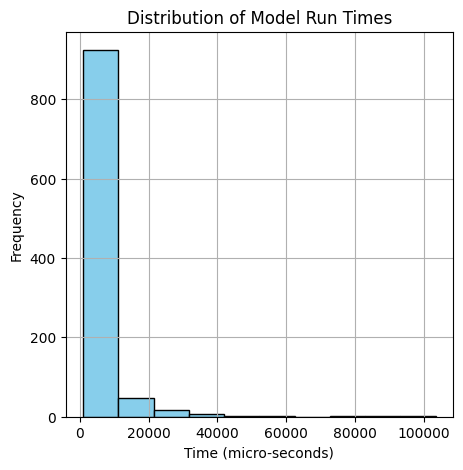

In [84]:
# Plotting the histogram
plt.figure(figsize=(5, 5))
plt.hist(list_compute_time, bins=10, edgecolor='black', color='skyblue')
plt.title('Distribution of Model Run Times')
plt.xlabel('Time (micro-seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()